<h1>Feature Extraction</h1>

In [5]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Import Data and Restate Variables**

In [6]:
train_data_num = pd.read_pickle('data/model/train_data_num.pkl')
test_data_num = pd.read_pickle('data/model/test_data_num.pkl')

vars_cont = ['Age', 'Flight Distance', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']

vars_cat_num = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']

vars_cat_str = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

**Normalizing Arrival Delay via Distance Traveled**

Although, delays in Arrival and Departure times could be useful features that impact passenger satisfaction, another idea for feature generation would be to normalize them by the distance traveled. <br/>Assuming, a more or less constant flight velocity, normalizing the delays with distance traveled would let us calculate how long the delay was with respect to the total expected flight time. <br/>
This relative delay penalty could be thought to play into the passengers satisfaction response (e.g. same amount of delay could be more tolerable in a long flight than short)


<h2>Variable Normalizing Delay with Total Flight Time</h2>


**Introduce Relative Delays**<br/>

In [18]:
Rel_Arr_Delay_train = train_data_num['Arrival Delay in Minutes']/train_data_num['Flight Distance']
Rel_Dep_Delay_train = train_data_num['Departure Delay in Minutes']/train_data_num['Flight Distance']
Rel_Arr_Delay_test = test_data_num['Arrival Delay in Minutes']/train_data_num['Flight Distance']
Rel_Dep_Delay_test = test_data_num['Departure Delay in Minutes']/train_data_num['Flight Distance']

_rel_delay_compare = pd.DataFrame({'Rel_Arr_Delay_train':Rel_Arr_Delay_train, 
                                 'Rel_Dep_Delay_train':Rel_Dep_Delay_train, 
                               'Arrival Delay in Minutes':train_data_num['Arrival Delay in Minutes'],
                                'Departure Delay in Minutes':train_data_num['Departure Delay in Minutes'],
                                'satisfaction':train_data_num['satisfaction']})

**Observe Correlations with 'satisfaction'**<br/>
Below we present the correlations of the relative delays and absolute delays with passenger satisfaction.<br/>
The relative delays seem to be more hightly correlated than the absolute ones - giving some optimism that feauture could benefit the model.

In [22]:
print(_rel_delay_compare.corr()['satisfaction'])

Rel_Arr_Delay_train          -0.085098
Rel_Dep_Delay_train          -0.080979
Arrival Delay in Minutes     -0.057582
Departure Delay in Minutes   -0.050494
satisfaction                  1.000000
Name: satisfaction, dtype: float64


**Observe Correlations with non-normalized delays**<br/>Also below, we present the correlations of the relative delays with absolute delays and passenger satisfaction.<br/>
The relative delay pair seems to be different than the absolute delay pair. This could mean that the normalization we introduced has had an impact on the absolute delay variables. Once again, good news.

In [23]:
print(_rel_delay_compare.corr()['Departure Delay in Minutes'])

Rel_Arr_Delay_train           0.625034
Rel_Dep_Delay_train           0.652296
Arrival Delay in Minutes      0.965481
Departure Delay in Minutes    1.000000
satisfaction                 -0.050494
Name: Departure Delay in Minutes, dtype: float64


Given the above, let's add one of the relative delay variables into our model. Given people might care more about the relative delay in arrival, let's choose to include that. 

In [109]:
train_data_num['Relative Arrival Delay'] = Rel_Arr_Delay_train
test_data_num['Relative Arrival Delay'] = Rel_Arr_Delay_test

train_data_final = train_data_num.copy()
test_data_final = test_data_num.copy()

**Average 'satisfaction' per bins of Relative Delay**<br/>
Before we end the section, we can also check if our assumption about longer relative wait times being worse might appear in the data. <br/>
Below is a satisfaction graph by quantiles.

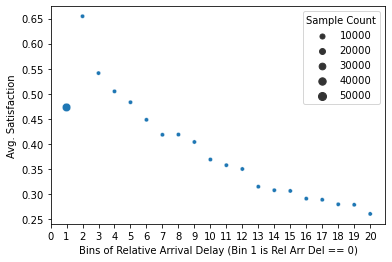

In [111]:
_, bin_pos =  pd.qcut(Rel_Arr_Delay_train[Rel_Arr_Delay_train > 0], 
                                         q=19, retbins=True)
bins = np.insert(bin_pos, 0, -1)

_df = pd.DataFrame({'Rel_Arr_Delay':Rel_Arr_Delay_train, 
                    'satisfaction':train_data_final['satisfaction']})

_df['bins'] = pd.cut(_df['Rel_Arr_Delay'], bins=bins, 
                     labels = list(range(1,21)))

_df_pivot = _df.pivot_table(index='bins', values=['Rel_Arr_Delay','satisfaction'], aggfunc=['count', 'mean'])
_df_pivot['Sample Count'] = _df_pivot['count']['satisfaction']
_df_pivot['Avg. Satisfaction'] = _df_pivot['mean']['satisfaction']
_df_pivot['Percent Delay'] = _df_pivot['mean']['Rel_Arr_Delay']
_df_pivot.drop(['count', 'mean'], axis=1, inplace=True)
_df_pivot.reset_index()
#print(_df_pivot)
ax = sns.scatterplot(y='Avg. Satisfaction', x=_df_pivot.index, size='Sample Count', data = _df_pivot)
ax.set_xticks(range(0,21))
ax.set_xlabel('Bins of Relative Arrival Delay (Bin 1 is Rel Arr Del == 0)')
print()

**One Last Look at Relative Arrival Delay with Delay > 0**<br/>
We will save the variables and move on to the next stage: Feature ExtractionThe graph above suggests an interesting point - that Bin 0 (the case where delay is zero) disrupts a trend we see in the remaining bins.<br/>
So, Bin 0 may not be as informative as we think in making a classification.<br/>
Given this, it may make sense to judge discrinating power of Relative Arrival Delay for beyond 0 delay.

In [114]:
Rel_Arr_Delay_filter = train_data_final['Relative Arrival Delay']>0
train_data_final[['Relative Arrival Delay' , 'Arrival Delay in Minutes', 'satisfaction']]\
              [Rel_Arr_Delay_filter].corr()

,Relative Arrival Delay,Arrival Delay in Minutes,satisfaction
Relative Arrival Delay,1.000000,0.607437,-0.092775
Arrival Delay in Minutes,0.607437,1.000000,-0.030345
satisfaction,-0.092775,-0.030345,1.000000


We see that the correlation of 'Relative Arrival Delay' with 'satisfaction' is even stronger for values greater than zero while that of 'Arrival Delay in Minutes' is now less.<br/> 
This gives us more assurance that the introduction of the new variable was a good idea.<br/>

**Save Variables**<br/>
We will save the variables and move on to the next stage: Modelling

In [115]:
pd.to_pickle(train_data_final, 'data/model/train_data_final_pkl')
pd.to_pickle(test_data_final, 'data/model/test_data_final_pkl')